In [ ]:
# tutorial followed for reference:
# https://github.com/Kyubyong/nlp_made_easy/blob/master/Pos-tagging%20with%20Bert%20Fine-tuning.ipynb

#Setup and functions

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from transformers import BertModel, BertTokenizer, BertForTokenClassification, XLMRobertaTokenizer, XLMRobertaModel
import pandas as pd
import torch
import torch.nn as nn
from torch.utils import data
import numpy as np

In [3]:
import sklearn
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

In [4]:
tag2idx = {'X': 0, 'PART': 1, 'AUX': 2, 'PUNCT': 3, '<pad>': 4, 'CONJ': 5, 'PRON': 6, 'INTJ': 7, 'NOUN': 8, 'VERB': 9, 'NUM': 10, 'SCONJ': 11, 'DET': 12, 'PROPN': 13, 'ADP': 14, 'ADV': 15, 'ADJ': 16}
idx2tag = {0: 'X', 1: 'PART', 2: 'AUX', 3: 'PUNCT', 4: '<pad>', 5: 'CONJ', 6: 'PRON', 7: 'INTJ', 8: 'NOUN', 9: 'VERB', 10: 'NUM', 11: 'SCONJ', 12: 'DET', 13: 'PROPN', 14: 'ADP', 15: 'ADV', 16: 'ADJ'}

In [5]:
class PosDataset(data.Dataset):
    def __init__(self, tokenizer, datafile):
        self.tokenizer = tokenizer
        with open(datafile, 'r') as f:
            lines = f.readlines()
            processed_data = [["[CLS]","<pad>"]]
            for line in lines:
                if line == "\n":
                    processed_data.append(["[SEP]","<pad>"])
                    processed_data.append(["[CLS]","<pad>"])
                else:
                    # Split word and label by whitespace
                    word, label = line.split("	")
                    if label[:-1] == 'SYM': label = 'X\n'
                    if label[:-1] == 'UNK': label = 'X\n'
                    if label[:-1] == 'CCONJ': label = 'CONJ\n'
                    if word  != "_" and label[:-1] != "_": processed_data.append([word, label[:-1]])

            # Create a pandas DataFrame
            df = pd.DataFrame(processed_data[:-1], columns=["word", "tag"])

        words = df['word'].values
        tags = df['tag'].values

        sentences, sentence_tags = [], []
        for i, word in enumerate(words):
            if word == "[CLS]": cls_index = i
            if word == "[SEP]":
                sentences.append(words[cls_index:i+1])
                sentence_tags.append(tags[cls_index:i+1])

        self.sentences, self.sentence_tags = sentences, sentence_tags

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words, tags = self.sentences[idx], self.sentence_tags[idx] #get this sentence at idx
        word_ids, tag_ids = [], [] # lists of ids
        is_head_list = [] # list. 1: the token is the first piece of a word

        for word, tag in zip(words, tags):
            tokens = self.tokenizer.tokenize(word) if word not in ("[CLS]", "[SEP]") else [word]
            this_word_ids = self.tokenizer.convert_tokens_to_ids(tokens)

            is_head = [1] + [0]*(len(tokens) - 1)

            tag = [tag] + ["<pad>"] * (len(tokens) - 1)  # <PAD>: no decision
            this_tag_ids = [tag2idx[each] for each in tag]  # (T,)


            word_ids.extend(this_word_ids)
            is_head_list.extend(is_head)
            tag_ids.extend(this_tag_ids)

            seq_length = len(word_ids)

        return words, tags, word_ids, tag_ids, is_head_list, seq_length

In [6]:
MAX_LEN = 140 #len of longest sentence in data: 140 for cs, 40 for eng
batch_size = 32

In [7]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [8]:
def pad(batch):
    '''Pads to the longest sample'''
    #sample: (words, tags, word_ids, tag_ids, is_head_list, seq_length)
    words = [sample[0] for sample in batch]
    tags = [sample[1] for sample in batch]
    is_head_list = [sample[4] for sample in batch]
    seq_lengths = [sample[5] for sample in batch]
    maxlen = np.array(seq_lengths).max()

    word_ids = [sample[2] + [0] * (maxlen - len(sample[2])) for sample in batch] # pad with 0s at end
    tag_ids = [sample[3] + [0] * (maxlen - len(sample[3])) for sample in batch]

    attention_masks = [[1] * len(sample[2]) + [0] * (maxlen - len(sample[2])) for sample in batch]

    return words, tags, torch.LongTensor(word_ids), torch.LongTensor(tag_ids), torch.LongTensor(attention_masks), is_head_list, seq_lengths

In [9]:
def train(model, iterator, optimizer, criterion, num_epochs, max_grad_norm):

    model.to(device)

    for _ in range(num_epochs):
        model.train()
        total_loss = 0

        for step, batch in enumerate(iterator):
            words, tags = batch[0], batch[1]
            word_ids = batch[2].to(device)
            tag_ids = batch[3].to(device)
            attention_masks = batch[4].to(device)
            is_heads, seq_lens = batch[5], batch[6]

            model.zero_grad()
            outputs = model(word_ids, attention_mask=attention_masks, labels=tag_ids)
            loss = outputs[0]
            loss.backward()
            total_loss += loss.item()
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
            optimizer.step()

            if step%50==0: # monitoring
                print("step: {}, loss: {}".format(step, loss.item()))

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(iterator)
        print("Average train loss: {}".format(avg_train_loss))

In [10]:
num_epochs = 10
max_grad_norm = 1.0

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [12]:
# torch.cuda.get_device_name(0)

In [18]:
def eval(model, iterator, dataset):
    model.eval()

    Words, Is_heads, Tags, Tag_ids, Pred_ids = [], [], [], [], []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            words, tags = batch[0], batch[1]
            word_ids = batch[2].to(device)
            tag_ids = batch[3].to(device)
            attention_masks = batch[4].to(device)
            is_heads, seq_lens = batch[5], batch[6]

            outputs = model(word_ids, attention_mask=attention_masks, labels=tag_ids)
            loss = outputs[0].item()
            pred_ids = outputs[1].argmax(-1)
            Words.extend(words)
            Is_heads.extend(is_heads)
            Tags.extend(tags)
            Tag_ids.extend(tag_ids.cpu().numpy().tolist())
            Pred_ids.extend(pred_ids.cpu().numpy().tolist())

    ## gets results and save
    with open("result", 'w') as fout:
        for words, is_heads, tags, pred_ids in zip(Words, Is_heads, Tags, Pred_ids):
            pred_ids = [hat for head, hat in zip(is_heads, pred_ids) if head == 1]
            preds = [idx2tag[hat] for hat in pred_ids]
            assert len(preds)==len(words)==len(tags)
            for w, t, p in zip(words[1:-1], tags[1:-1], preds[1:-1]):
                fout.write("{} {} {}\n".format(w, t, p))
            fout.write("\n")

    ## calc metric
    y_true =  np.array([tag2idx[line.split()[1]] for line in open('result', 'r').read().splitlines() if len(line) > 0])
    y_pred =  np.array([tag2idx[line.split()[2]] for line in open('result', 'r').read().splitlines() if len(line) > 0])

    acc = (y_true==y_pred).astype(np.int32).sum() / len(y_true)

    print("Accuracy: %.2f"%acc)

    return y_true, y_pred

#Train on CS:

In [ ]:
train_dataset = PosDataset(tokenizer, 'final-proj-dataset/pos/cs_pos/train-parsed.conll')
train_dataset.sentences = train_dataset.sentences[:1394]
train_dataset.sentence_tags = train_dataset.sentence_tags[:1394]

model = BertForTokenClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

train_iter = data.DataLoader(dataset=train_dataset,
                             batch_size=32,
                             shuffle=False,
                             collate_fn=pad)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

criterion = nn.CrossEntropyLoss(ignore_index=0)

model.safetensors:  38%|###8      | 273M/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
train(model, train_iter, optimizer, criterion, num_epochs, max_grad_norm)

step: 0, loss: 2.843987464904785
Average train loss: 0.46671396430412476
step: 0, loss: 0.09753526002168655
Average train loss: 0.046811475164510986
step: 0, loss: 0.05057603865861893
Average train loss: 0.027905477888204834
step: 0, loss: 0.017086857929825783
Average train loss: 0.019723057260059497
step: 0, loss: 0.013691321946680546
Average train loss: 0.014565934204835106
step: 0, loss: 0.0041452995501458645
Average train loss: 0.011061436644839969
step: 0, loss: 0.0035463827662169933
Average train loss: 0.009329275286290795
step: 0, loss: 0.012134555727243423
Average train loss: 0.009304401644674892
step: 0, loss: 0.005918328650295734
Average train loss: 0.008345320214919577
step: 0, loss: 0.005453505087643862
Average train loss: 0.008781182131232608


In [ ]:
torch.save(model,'pos_cs_model.pt')

In [30]:
#model=torch.load('/content/drive/My Drive/Colab_Notebooks/cl2-code-switching-plm/pos_cs_model.pt').to(device)

<ipython-input-30-143adb396ca3>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model=torch.load('/content/drive/My Drive/Colab_Notebooks/cl2-code-switching-plm/pos_cs_mode

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
model=torch.load('pos_cs_model.pt', map_location=torch.device('cpu'))

<ipython-input-11-c800d06f92f0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model=torch.load('/content/drive/My Drive/Colab_Notebooks/cl2-code-switching-plm/pos_cs_mode

In [ ]:
val_dataset = PosDataset(tokenizer, 'final-proj-dataset/pos/cs_pos/valid-parsed.conll')
val_iter = data.DataLoader(dataset=val_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

test_dataset = PosDataset(tokenizer, 'final-proj-dataset/pos/cs_pos/test-parsed.conll')
test_dataset.sentences = test_dataset.sentences[:1200]
test_dataset.sentence_tags = test_dataset.sentence_tags[:1200]

test_iter = data.DataLoader(dataset=test_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

In [24]:
y_true, y_pred = eval(model, test_iter, test_dataset)

Accuracy: 0.94


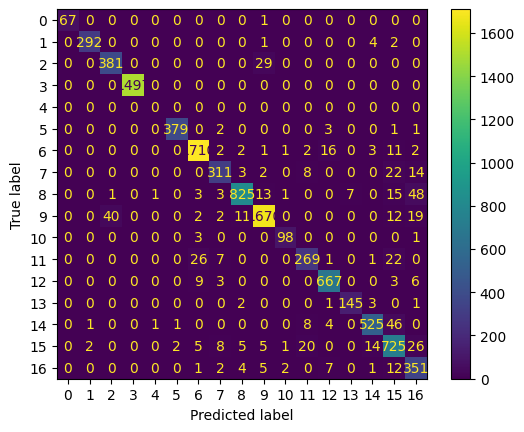

In [27]:
# confusion_matrix(y_true, y_pred, labels=list(train_dataset.tag2idx.values()))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=list(tag2idx.values()))

In [23]:
open('result', 'r').read().splitlines()[:100]

['no INTJ INTJ',
 'pero CONJ CONJ',
 'yo PRON PRON',
 're X VERB',
 '... PUNCT PUNCT',
 'tengo VERB VERB',
 'todavía ADV ADV',
 'en ADP ADP',
 'la DET DET',
 'casa NOUN NOUN',
 'un DET DET',
 'sobre ADP ADV',
 'así ADV ADV',
 '... PUNCT PUNCT',
 '',
 'before SCONJ SCONJ',
 'it PRON PRON',
 'can AUX AUX',
 'go VERB VERB',
 'through ADP ADP',
 'the DET DET',
 'whole ADJ ADJ',
 'screening NOUN NOUN',
 'and CONJ CONJ',
 'downtown NOUN ADJ',
 'screens NOUN NOUN',
 'them PRON PRON',
 'and CONJ CONJ',
 'everything PRON PRON',
 'sometimes ADV ADV',
 'three NUM NUM',
 'times NOUN NOUN',
 'they PRON PRON',
 'have AUX AUX',
 'to PART PART',
 'do VERB VERB',
 'it PRON PRON',
 '. PUNCT PUNCT',
 '',
 'no INTJ ADV',
 'es VERB VERB',
 'que SCONJ SCONJ',
 'a ADP ADP',
 'mí PRON PRON',
 'me PRON PRON',
 'tenían VERB VERB',
 '<unintelligible> X X',
 '. PUNCT PUNCT',
 '',
 '<unintelligible> X X',
 'con ADP ADP',
 'esto PRON PRON',
 '. PUNCT PUNCT',
 '',
 'ten NUM NUM',
 '? PUNCT PUNCT',
 '',
 'da+ VERB VE

In [22]:
MAX_LEN = 40

In [ ]:
eng_test_dataset = PosDataset(tokenizer, 'final-proj-dataset/pos/english_pos/en-ud-tweet-test-parsed.conll')

eng_test_iter = data.DataLoader(dataset=eng_test_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

In [29]:
eng_y_true, eng_y_pred = eval(model, eng_test_iter, eng_test_dataset)

Accuracy: 0.66


In [28]:
open('result', 'r').read().splitlines()[:100]

['new ADJ ADJ',
 'unique ADJ ADJ',
 'backpack NOUN NOUN',
 '! PUNCT PUNCT',
 'combines VERB VERB',
 'vintage NOUN NOUN',
 'with ADP ADP',
 'modern NOUN ADJ',
 '! PUNCT PUNCT',
 'URL1283 X NOUN',
 'via ADP NOUN',
 '@USER415 PROPN NOUN',
 '',
 'RT X PROPN',
 '@USER767 X NOUN',
 ': PUNCT <pad>',
 'It PRON PRON',
 "'s AUX AUX",
 'been AUX VERB',
 '3 NUM NUM',
 'years NOUN NOUN',
 'since ADP ADP',
 'the DET DET',
 'release NOUN NOUN',
 'of ADP ADP',
 'the DET DET',
 'music NOUN NOUN',
 'video NOUN NOUN',
 'of ADP ADP',
 'Burning VERB PROPN',
 'Desire NOUN PROPN',
 '. PUNCT PUNCT',
 'URL637 X PROPN',
 '',
 '#openfollow X <pad>',
 'for ADP ADP',
 'kpopers NOUN NOUN',
 'just ADV ADV',
 'retweet VERB NOUN',
 '',
 'RT X PROPN',
 '@USER526 X NOUN',
 ': PUNCT <pad>',
 'empathy NOUN NOUN',
 '4 ADP NUM',
 'Kesha PROPN PROPN',
 '.... PUNCT PUNCT',
 'the DET DET',
 'worst ADJ ADJ',
 '. PUNCT PUNCT',
 'smh INTJ INTJ',
 'smh INTJ INTJ',
 '.. PUNCT PUNCT',
 '💔 X PROPN',
 '',
 'RT X PROPN',
 '@USER2128 X 

In [ ]:
sp_test_dataset = PosDataset(tokenizer, 'final-proj-dataset/pos/spanish_pos/es_ancora-ud-test-parsed.conll')
sp_test_dataset.sentences = sp_test_dataset.sentences[:1200]
sp_test_dataset.sentence_tags = sp_test_dataset.sentence_tags[:120]

sp_test_iter = data.DataLoader(dataset=sp_test_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

In [31]:
sp_y_true, sp_y_pred = eval(model, sp_test_iter, sp_test_dataset)

Accuracy: 0.91


In [35]:
open('result', 'r').read().splitlines()[:100]

['Partidario ADJ PROPN',
 'de ADP ADP',
 'la DET DET',
 '" PUNCT PUNCT',
 'perestroika NOUN NOUN',
 '" PUNCT PUNCT',
 'de ADP ADP',
 'Mijail PROPN PROPN',
 'Gorbachov PROPN PROPN',
 'en ADP ADP',
 'la DET DET',
 'Unión PROPN PROPN',
 'Soviética PROPN PROPN',
 ', PUNCT <pad>',
 'en ADP ADP',
 '1989 NOUN NOUN',
 'entró VERB VERB',
 'en ADP ADP',
 'conflicto NOUN NOUN',
 'con ADP ADP',
 'Yívkov PROPN PROPN',
 ', PUNCT <pad>',
 'líder NOUN NOUN',
 'durante ADP ADP',
 '35 NUM NUM',
 'años NOUN NOUN',
 'de ADP ADP',
 'el DET DET',
 'Partido PROPN NOUN',
 'Comunista PROPN PROPN',
 'y CONJ CONJ',
 'de ADP ADP',
 'el DET DET',
 'Estado PROPN NOUN',
 'búlgaro ADJ NOUN',
 ', PUNCT <pad>',
 'y CONJ CONJ',
 'le PRON PRON',
 'acusó VERB VERB',
 'en ADP ADP',
 'una DET DET',
 'carta NOUN NOUN',
 'abierta ADJ ADJ',
 'de ADP ADP',
 'utilizar VERB VERB',
 'métodos NOUN NOUN',
 'poco ADV ADV',
 'democráticos ADJ ADJ',
 'de ADP ADP',
 'gobierno NOUN NOUN',
 '. PUNCT PUNCT',
 '',
 'Días NOUN PROPN',
 'desp

In [ ]:
all_test_dataset = PosDataset(tokenizer, 'final-proj-dataset/pos/cs_pos/test-parsed.conll')
all_test_dataset.sentences = all_test_dataset.sentences[:1200] + eng_test_dataset.sentences[:1200] + sp_test_dataset.sentences[:1200]
all_test_dataset.sentence_tags = all_test_dataset.sentence_tags[:1200] + eng_test_dataset.sentence_tags[:1200] + sp_test_dataset.sentence_tags[:1200]

all_test_iter = data.DataLoader(dataset=all_test_dataset,
                             batch_size=32,
                             shuffle=True,
                             num_workers=1,
                             collate_fn=pad)

In [44]:
eval(model, all_test_iter, all_test_dataset)

Accuracy: 0.85


(array([14, 12, 16, ..., 16,  8,  3]), array([14, 12, 16, ..., 16,  8,  3]))

#Train on Spanish:

In [ ]:
sp_train_dataset = PosDataset(tokenizer, 'final-proj-dataset/pos/spanish_pos/es_ancora-ud-test-parsed.conll')
sp_train_dataset.sentences = sp_train_dataset.sentences[:1394]
sp_train_dataset.sentence_tags = sp_train_dataset.sentence_tags[:1394]

MAX_LEN = 0
for sentence in sp_train_dataset.sentences:
  MAX_LEN = max(MAX_LEN, len(sentence))

sp_model = BertForTokenClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

sp_train_iter = data.DataLoader(dataset=sp_train_dataset,
                             batch_size=32,
                             shuffle=False,
                             collate_fn=pad)

optimizer = torch.optim.Adam(sp_model.parameters(), lr = 0.0001)

criterion = nn.CrossEntropyLoss(ignore_index=0)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
train(sp_model, sp_train_iter, optimizer, criterion, num_epochs, max_grad_norm)

step: 0, loss: 2.976341962814331
Average train loss: 0.4016522863795134
step: 0, loss: 0.05591490864753723
Average train loss: 0.03202993511645631
step: 0, loss: 0.03342919796705246
Average train loss: 0.01938403171317821
step: 0, loss: 0.01945042423903942
Average train loss: 0.013461600946770473
step: 0, loss: 0.02049228921532631
Average train loss: 0.008759545903144912
step: 0, loss: 0.00820594560354948
Average train loss: 0.005867783273887736
step: 0, loss: 0.009924406185746193
Average train loss: 0.004851617556679147
step: 0, loss: 0.008818277157843113
Average train loss: 0.004551126273740506
step: 0, loss: 0.004082982894033194
Average train loss: 0.00329838735871652
step: 0, loss: 0.00354674831032753
Average train loss: 0.004380739749070595


In [ ]:
#torch.save(sp_model,'pos_sp_model.pt')

In [ ]:
sp_model=torch.load('pos_sp_model.pt').to(device)

<ipython-input-18-d090bd64211a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sp_model=torch.load('/content/drive/My Drive/Colab_Notebooks/cl2-code-switching-plm/pos_sp_m

In [ ]:
sp_val_dataset = PosDataset(tokenizer, 'final-proj-dataset/pos/spanish_pos/es_ancora-ud-valid-parsed.conll')

sp_valid_iter = data.DataLoader(dataset=sp_val_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

In [38]:
eval(sp_model, sp_valid_iter,sp_val_dataset)

Accuracy: 0.98


(array([13,  2,  9, ...,  9,  3,  3]), array([13,  2,  9, ...,  9,  3,  3]))

In [ ]:
sp_test_dataset = PosDataset(tokenizer, 'final-proj-dataset/pos/spanish_pos/es_ancora-ud-test-parsed.conll')
sp_test_dataset.sentences = sp_test_dataset.sentences[:1200]
sp_test_dataset.sentence_tags = sp_test_dataset.sentence_tags[:1200]

sp_test_iter = data.DataLoader(dataset=sp_test_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

eval(sp_model, sp_test_iter,sp_test_dataset)

Accuracy: 1.00


(array([16, 14, 12, ...,  8, 16,  3]), array([16, 14, 12, ...,  8, 16,  3]))

In [22]:
open('result', 'r').read().splitlines()[:100]

['Partidario ADJ NOUN',
 'de ADP DET',
 'la DET ADJ',
 '" PUNCT INTJ',
 'perestroika NOUN ADP',
 '" PUNCT INTJ',
 'de ADP DET',
 'Mijail PROPN SCONJ',
 'Gorbachov PROPN SCONJ',
 'en ADP DET',
 'la DET ADJ',
 'Unión PROPN SCONJ',
 'Soviética PROPN SCONJ',
 ', PUNCT INTJ',
 'en ADP DET',
 '1989 NOUN ADP',
 'entró VERB VERB',
 'en ADP DET',
 'conflicto NOUN ADP',
 'con ADP DET',
 'Yívkov PROPN SCONJ',
 ', PUNCT INTJ',
 'líder NOUN ADP',
 'durante ADP DET',
 '35 NUM ADV',
 'años NOUN ADP',
 'de ADP DET',
 'el DET ADJ',
 'Partido PROPN SCONJ',
 'Comunista PROPN SCONJ',
 'y CONJ PART',
 'de ADP DET',
 'el DET ADJ',
 'Estado PROPN SCONJ',
 'búlgaro ADJ NOUN',
 ', PUNCT INTJ',
 'y CONJ PART',
 'le PRON AUX',
 'acusó VERB VERB',
 'en ADP DET',
 'una DET ADJ',
 'carta NOUN ADP',
 'abierta ADJ NOUN',
 'de ADP DET',
 'utilizar VERB VERB',
 'métodos NOUN ADP',
 'poco ADV PROPN',
 'democráticos ADJ NOUN',
 'de ADP DET',
 'gobierno NOUN ADP',
 '. PUNCT INTJ',
 '',
 'Días NOUN ADP',
 'después ADV PROP

In [ ]:
eng_test_dataset = PosDataset(tokenizer, 'final-proj-dataset/pos/english_pos/en-ud-tweet-test-parsed.conll')
eng_test_dataset.sentences = eng_test_dataset.sentences[:1200]
eng_test_dataset.sentence_tags = eng_test_dataset.sentence_tags[:1200]

eng_test_iter = data.DataLoader(dataset=eng_test_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

In [42]:
eval(sp_model, eng_test_iter, eng_test_dataset)

Accuracy: 0.66


(array([16, 16,  8, ...,  3,  0,  3]), array([16, 16,  8, ...,  3, 13,  3]))

In [46]:
eval(sp_model, test_iter, test_dataset)

Accuracy: 0.79


(array([ 7,  5,  6, ..., 11,  0,  3]), array([15,  5,  6, ..., 11,  3,  3]))

In [47]:
eval(sp_model, all_test_iter, all_test_dataset)

Accuracy: 0.87


(array([ 0,  0,  3, ...,  8, 16,  3]), array([13,  4,  3, ...,  8, 16,  3]))

#Train on English

In [ ]:
eng_train_dataset = PosDataset(tokenizer, 'final-proj-dataset/pos/english_pos/en-ud-tweet-train-parsed.conll')

MAX_LEN = 0
for sentence in eng_train_dataset.sentences:
  MAX_LEN = max(MAX_LEN, len(sentence))

eng_model = BertForTokenClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

eng_train_iter = data.DataLoader(dataset=eng_train_dataset,
                             batch_size=32,
                             shuffle=False,
                             collate_fn=pad)

optimizer = torch.optim.Adam(eng_model.parameters(), lr = 0.0001)

criterion = nn.CrossEntropyLoss(ignore_index=0)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
train(eng_model, eng_train_iter, optimizer, criterion, num_epochs, max_grad_norm)

step: 0, loss: 2.9363198280334473
Average train loss: 0.584618547253988
step: 0, loss: 0.21055299043655396
Average train loss: 0.10238624262538823
step: 0, loss: 0.09227057546377182
Average train loss: 0.05505565964532169
step: 0, loss: 0.06758087128400803
Average train loss: 0.03838750290345739
step: 0, loss: 0.041251298040151596
Average train loss: 0.02954337946985933
step: 0, loss: 0.03004319779574871
Average train loss: 0.021215213970704513
step: 0, loss: 0.027454275637865067
Average train loss: 0.01668272647922012
step: 0, loss: 0.019476301968097687
Average train loss: 0.01409195412204347
step: 0, loss: 0.020529240369796753
Average train loss: 0.010345468562181022
step: 0, loss: 0.011336294002830982
Average train loss: 0.00792275814720514


In [ ]:
#torch.save(eng_model,'pos_eng_model.pt')

In [ ]:
eng_model=torch.load('/content/drive/My Drive/Colab_Notebooks/cl2-code-switching-plm/pos_eng_model.pt').to(device)

In [ ]:
eng_val_dataset = PosDataset(tokenizer, 'final-proj-dataset/pos/english_pos/en-ud-tweet-valid-parsed.conll')

eng_val_iter = data.DataLoader(dataset=eng_val_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

# eng_test_dataset = PosDataset(tokenizer, '/content/drive/My Drive/Colab_Notebooks/cl2-code-switching-plm/final-proj-dataset/pos/english_pos/en-ud-tweet-test-parsed.conll')
# eng_test_dataset.tag2idx = eng_train_dataset.tag2idx
# eng_test_dataset.idx2tag = eng_train_dataset.idx2tag

# eng_test_iter = data.DataLoader(dataset=eng_test_dataset,
#                              batch_size=32,
#                              shuffle=False,
#                              num_workers=1,
#                              collate_fn=pad)

In [51]:
eval(eng_model, eng_val_iter, eng_val_dataset)

Accuracy: 0.93


(array([13,  9,  3, ...,  8,  8,  3]), array([13,  9,  3, ..., 13,  8,  3]))

In [52]:
eval(eng_model, eng_test_iter, eng_test_dataset)

Accuracy: 0.93


(array([16, 16,  8, ...,  3,  0,  3]), array([16, 16,  8, ...,  3,  0,  3]))

In [54]:
eval(eng_model, sp_test_iter, sp_test_dataset)

Accuracy: 0.87


(array([16, 14, 12, ...,  8, 16,  3]), array([ 8, 14, 12, ...,  8,  9,  3]))

In [38]:
open('result', 'r').read().splitlines()[:100]

['Partidario ADJ NOUN',
 'de ADP ADP',
 'la DET DET',
 '" PUNCT PUNCT',
 'perestroika NOUN NOUN',
 '" PUNCT PUNCT',
 'de ADP ADP',
 'Mijail PROPN PROPN',
 'Gorbachov PROPN PROPN',
 'en ADP ADP',
 'la DET DET',
 'Unión PROPN PROPN',
 'Soviética PROPN PROPN',
 ', PUNCT PUNCT',
 'en ADP ADP',
 '1989 NOUN NUM',
 'entró VERB VERB',
 'en ADP ADP',
 'conflicto NOUN NOUN',
 'con ADP ADP',
 'Yívkov PROPN PROPN',
 ', PUNCT PUNCT',
 'líder NOUN NOUN',
 'durante ADP ADP',
 '35 NUM NUM',
 'años NOUN NOUN',
 'de ADP ADP',
 'el DET DET',
 'Partido PROPN PROPN',
 'Comunista PROPN PROPN',
 'y CONJ CONJ',
 'de ADP ADP',
 'el DET DET',
 'Estado PROPN PROPN',
 'búlgaro ADJ PROPN',
 ', PUNCT PUNCT',
 'y CONJ CONJ',
 'le PRON PRON',
 'acusó VERB VERB',
 'en ADP ADP',
 'una DET DET',
 'carta NOUN NOUN',
 'abierta ADJ ADJ',
 'de ADP PART',
 'utilizar VERB VERB',
 'métodos NOUN NOUN',
 'poco ADV ADV',
 'democráticos ADJ ADJ',
 'de ADP ADP',
 'gobierno NOUN NOUN',
 '. PUNCT PUNCT',
 '',
 'Días NOUN NOUN',
 'des

In [55]:
eval(eng_model, test_iter, test_dataset)

Accuracy: 0.81


(array([ 7,  5,  6, ..., 11,  0,  3]), array([ 7,  5,  6, ..., 11,  3,  4]))

In [56]:
eval(eng_model, all_test_iter, all_test_dataset)

Accuracy: 0.88


(array([15, 14,  6, ...,  9,  6,  0]), array([14, 14,  6, ...,  9,  6,  3]))

#Train on bilingual

In [57]:
bi_train_dataset = eng_train_dataset
bi_train_dataset.sentences = bi_train_dataset.sentences[:697] + sp_train_dataset.sentences[:697]
bi_train_dataset.sentence_tags = bi_train_dataset.sentence_tags[:697] + sp_train_dataset.sentence_tags[:697]

bi_train_iter = data.DataLoader(dataset=bi_train_dataset,
                             batch_size=32,
                             shuffle=True,
                              num_workers=1,
                             collate_fn=pad)

MAX_LEN = 0
for sentence in bi_train_dataset.sentences:
  MAX_LEN = max(MAX_LEN, len(sentence))

bi_model = BertForTokenClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

optimizer = torch.optim.Adam(bi_model.parameters(), lr = 0.0001)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
train(bi_model, bi_train_iter, optimizer, criterion, num_epochs, max_grad_norm)

step: 0, loss: 2.9922268390655518
Average train loss: 0.44177369434725156
step: 0, loss: 0.0840005874633789
Average train loss: 0.05068235687742179
step: 0, loss: 0.02316666953265667
Average train loss: 0.028420089998028496
step: 0, loss: 0.01295404601842165
Average train loss: 0.017174196461300282
step: 0, loss: 0.017332367599010468
Average train loss: 0.013366076994729652
step: 0, loss: 0.016111254692077637
Average train loss: 0.009455931277691641
step: 0, loss: 0.006137061398476362
Average train loss: 0.007395991626915268
step: 0, loss: 0.0032341862097382545
Average train loss: 0.005195107948648828
step: 0, loss: 0.007112639956176281
Average train loss: 0.005342379365836016
step: 0, loss: 0.0048830281011760235
Average train loss: 0.005105995157712393


In [ ]:
#torch.save(bi_model,'pos_bi_model.pt')

In [59]:
eval(bi_model, eng_test_iter, eng_test_dataset)

Accuracy: 0.91


(array([16, 16,  8, ...,  3,  0,  3]), array([16, 16,  8, ...,  3,  0,  3]))

In [60]:
eval(bi_model, sp_test_iter, sp_test_dataset)

Accuracy: 0.99


(array([16, 14, 12, ...,  8, 16,  3]), array([16, 14, 12, ...,  8, 16,  3]))

In [61]:
eval(bi_model, test_iter, test_dataset)

Accuracy: 0.84


(array([ 7,  5,  6, ..., 11,  0,  3]), array([15,  5,  6, ..., 11,  3,  3]))

In [62]:
eval(bi_model, all_test_iter, all_test_dataset)

Accuracy: 0.95


(array([ 0,  0,  3, ...,  8, 16,  3]), array([ 0,  0,  3, ...,  8, 16,  3]))